In [1]:
from datasets import load_dataset

In [2]:
import spacy

In [3]:
ds = load_dataset("argilla/medical-domain")
train_data = ds['train']

In [10]:
def inspect_data(data, num_samples=5):
    # Print out the full structure of dataset
    for i, item in enumerate(data[:num_samples], 1):
        print(f"Features {i}: {item}\n")

    # Print out the structure and content of the first few data entries
    for i in range(num_samples):
        sample = data[i]
        print(f"Sample {i+1}: {sample}\n")

# Run the inspection of data
inspect_data(train_data)

Features 1: text

Features 2: inputs

Features 3: prediction

Features 4: prediction_agent

Features 5: annotation

Features 6: annotation_agent

Features 7: multi_label

Features 8: explanation

Features 9: id

Features 10: metadata

Features 11: status

Features 12: event_timestamp

Features 13: metrics

Sample 1: {'text': 'PREOPERATIVE DIAGNOSIS:,  Iron deficiency anemia.,POSTOPERATIVE DIAGNOSIS:,  Diverticulosis.,PROCEDURE:,  Colonoscopy.,MEDICATIONS: , MAC.,PROCEDURE: , The Olympus pediatric variable colonoscope was introduced into the rectum and advanced carefully through the colon to the cecum identified by the ileocecal valve and the appendiceal orifice.  Preparation was good, although there was some residual material in the cecum that was difficult to clear completely.  The mucosa was normal throughout the colon.  No polyps or other lesions were identified, and no blood was noted.  Some diverticula were seen of the sigmoid colon with no luminal narrowing or evidence of inflamm

## Standard and potential new NER types
- Standard NER types that are prominent in our data are Persons, dates, times, locations, organizations (ex. department)
- Potential new NER types that are prominent in our data are diagnosis, symptoms, treatment, and lab values. 

## Investigate LLM-based NER
### Utilizing Chatbots

In [13]:
train_data_trunc = train_data.select(range(10))

In [16]:
import subprocess
import os
import csv

def query_model(prompt, model, size):
    # Run the Ollama command in the terminal
    result = subprocess.run(
        ["ollama", "run", f"{model}:{size}"],
        input=prompt,
        text=True,
        capture_output=True
    )
    return result.stdout

def process_all_text_entries(data, model, size, csv_writer):
    for idx, item in enumerate(data):
        document_text = item['text']  # Extract the 'text' field from each entry
        print(document_text[:200])
        
        # Updated prompt to extract all NER types
        prompt = f"You are a helpful assistant tasked with extracting all named entities from the following text. For each entity, create a numbered list specifying the type (e.g., PERSON, ORGANIZATION, LOCATION, DATE, DIAGNOSIS, TREATMENT, etc.): {document_text}. Respond ONLY with this list of entities and their types."
        response = query_model(prompt=prompt, model=model, size=size)
        
        # Print response for each entry (optional)
        print(f"Response for entry {idx} using {model} {size}:\n{response}\n")
        
        # Write the response to the CSV file
        csv_writer.writerow([model, size, document_text[:200] + '...', response])  # Include only part of the text for brevity


# Create the CSV file and add headers
output_csv_path = "model_responses.csv"
with open(output_csv_path, mode="w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    # Write the header
    csv_writer.writerow(["Model Name", "Model Size", "Text Sample", "Response to Prompt"])

    # Call the function for each model and size configuration
    process_all_text_entries(train_data_trunc, "llama3.2", "3b", csv_writer)
    #process_all_text_entries(train_data, "llama3.1", "8b", csv_writer)

print(f"Responses have been saved to {output_csv_path}")

PREOPERATIVE DIAGNOSIS:,  Iron deficiency anemia.,POSTOPERATIVE DIAGNOSIS:,  Diverticulosis.,PROCEDURE:,  Colonoscopy.,MEDICATIONS: , MAC.,PROCEDURE: , The Olympus pediatric variable colonoscope was i
Response for entry 0 using llama3.2 3b:
1. Iron deficiency anemia - DIAGNOSIS
2. Diverticulosis - DIAGNOSIS
3. MAC - MEDICATIONS
4. Olympus pediatric variable colonoscope - ORGANIZATION
5. Dr. X - PERSON



CLINICAL INDICATION:  ,Normal stress test.,PROCEDURES PERFORMED:,1.  Left heart cath.,2.  Selective coronary angiography.,3.  LV gram.,4.  Right femoral arteriogram.,5.  Mynx closure device.,PROCEDURE
Response for entry 1 using llama3.2 3b:
1. Left heart cath (PROCEDURE)
2. Selective coronary angiography (PROCEDURE)
3. LV gram (PROCEDURE)
4. Right femoral arteriogram (PROCEDURE)
5. Mynx closure device (PROCEDURE)
6. Lidocaine (SUBSTANCE)
7. 2% lidocaine (SUBSTANCE)
8. LVEDP (MEASUREMENT)
9. Left main (ANATOMY)
10. LAD (ANATOMY)
11. Left circumflex (ANATOMY)
12. Right coronary artery (A

#### *Conclusions*

- It is relatively simple to run LLama3.2 locally. However, it needs GPUs to run efficiently
- Because Llama is designed to take an input prompt and generate text in response, it is suitable for conversational AI, interactive querying, and generating outputs based on a range of instructions
- This allowed the model to identify NER that goes beyond SpaCy's capabilities, identifying medicines, body parts, medical procedures, etc.
- However, each output was in different formats. For ideal results, careful prompt engineering and post processing would be necessary.
- After adjustments to the prompt (giving the AI a role, asking for a specific format, limiting the response to just the specified format and no additional words) the responses improved immensely

### Applying NER Models

In [29]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# Load the model and tokenizer
model_name = "dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

### Possible models to choose from
### Universal-NER/UniNER-7B-type-sup
### emilyalsentzer/Bio_ClinicalBERT
### bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]
Some weights of LlamaForTokenClassification were not initialized from the model checkpoint at Universal-NER/UniNER-7B-type-sup and are newly initialized: ['score.bias', 'score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
# Create the NER pipeline
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer) # runs the specific model in NER mode

# Example text
text = "John Doe was diagnosed with Type 2 Diabetes on 2024-11-10."

# Perform NER
entities = nlp_ner(text)

# Print out the recognized entities
for ent in entities:
    print(f"Entity: {ent['word']}, Label: {ent['entity']}, Score: {ent['score']:.4f}")

Entity: ▁John, Label: LABEL_1, Score: 0.9788
Entity: ▁Do, Label: LABEL_1, Score: 0.8528
Entity: e, Label: LABEL_1, Score: 0.9956
Entity: ▁was, Label: LABEL_0, Score: 0.8023
Entity: ▁diagn, Label: LABEL_0, Score: 0.6978
Entity: osed, Label: LABEL_0, Score: 0.9122
Entity: ▁with, Label: LABEL_0, Score: 0.5410
Entity: ▁Type, Label: LABEL_1, Score: 0.5749
Entity: ▁, Label: LABEL_1, Score: 0.8181
Entity: 2, Label: LABEL_1, Score: 0.9712
Entity: ▁Di, Label: LABEL_1, Score: 0.9771
Entity: ab, Label: LABEL_1, Score: 0.9787
Entity: etes, Label: LABEL_1, Score: 0.7363
Entity: ▁on, Label: LABEL_0, Score: 0.9951
Entity: ▁, Label: LABEL_0, Score: 0.9337
Entity: 2, Label: LABEL_0, Score: 0.7496
Entity: 0, Label: LABEL_0, Score: 0.6739
Entity: 2, Label: LABEL_0, Score: 0.6688
Entity: 4, Label: LABEL_0, Score: 0.9242
Entity: -, Label: LABEL_0, Score: 0.6383
Entity: 1, Label: LABEL_0, Score: 0.5003
Entity: 1, Label: LABEL_0, Score: 0.8396
Entity: -, Label: LABEL_0, Score: 0.7545
Entity: 1, Label: LABEL_

# To do next

Fine-tune the Model on a Custom Dataset
If the predefined labels of the model (dslim/bert-base-NER) don't include DIAGNOSIS or other desired labels, you need to fine-tune it on a dataset that includes these entities.

Prepare a Custom Dataset:

Annotate text data with your desired entity labels (PERSON, DIAGNOSIS, DATE, etc.).
Format it in a standard format like CoNLL or JSONL (depending on the tokenizer and training framework).
Fine-tune the Model:

Use the transformers library to fine-tune the model on your annotated dataset.
Adjust the num_labels argument during model definition to match your label count.
Example guide for fine-tuning: Hugging Face Fine-Tuning Tutorial.

#### *Conclusions*

- Loading the model took the longest in this process
- This model was trained for the task of extracting NER from text, and was on the clinical NER leaderboard on Hugging Face
- The outputs on this test statement show that the entities that were extracted are not specific to the medical field, meaning that fine tuning would be needed to use this on our data

Get annotations


In [4]:
# Extract the first 100 samples from the dataset
first_100_samples = train_data.select(range(100))

In [5]:
import pandas as pd
import ast

# Load the CSV file
input_file = "annotations_gt.csv"
df = pd.read_csv(input_file)

# Parse the annotations from the 'entities' column
annotations = []
for _, row in df.iterrows():
    text = row['text']  # Extract the text
    entities_str = row['entities']  # Extract the entities as a string
    entities = ast.literal_eval(entities_str)  # Convert string back to list of tuples
    annotations.append({'text': text, 'entities': entities})

# Display the annotations
print(annotations)


[{'text': '        "PREOPERATIVE DIAGNOSIS:,  Iron deficiency anemia.,POSTOPERATIVE DIAGNOSIS:,  Diverticulosis.,PROCEDURE:,  Colonoscopy.,MEDICATIONS: , MAC.,PROCEDURE: , The Olympus pediatric variable colonoscope was introduced into the rectum and advanced carefully through the colon to the cecum identified by the ileocecal valve and the appendiceal orifice.  Preparation was good, although there was some residual material in the cecum that was difficult to clear completely.  The mucosa was normal throughout the colon.  No polyps or other lesions were identified, and no blood was noted.  Some diverticula were seen of the sigmoid colon with no luminal narrowing or evidence of inflammation.  A retroflex view of the anorectal junction showed no hemorrhoids.  The patient tolerated the procedure well and was sent to the recovery room.,FINAL DIAGNOSES:,1.  Diverticulosis in the sigmoid.,2.  Otherwise normal colonoscopy to the cecum.,RECOMMENDATIONS:,1.  Follow up with Dr. X as needed.,2.  S

In [14]:
print(annotations[0]['entities'][0])

('Iron deficiency anemia', 'MEDICAL DIAGNOSIS')


Using a model for NER 

In [5]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# Load the model and tokenizer
model_name = "samrawal/bert-base-uncased_clinical-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [6]:
import torch
device_index = 0 if torch.cuda.is_available() else -1  # Use 0 for GPU, -1 for CPU
# Create the NER pipeline
nlp_ner = pipeline("ner", model=model, tokenizer=tokenizer, device = device_index) # runs the specific model in NER mode

In [ ]:
# Process data and extract entities
entities = nlp_ner(train_data['text'])

In [13]:
# To verify, print
for entity in entities:
    for ent in entity:
        print(f"Entity: {ent['word']}, Label: {ent['entity']}, Score: {ent['score']:.4f}")

Entity: iron, Label: B-problem, Score: 0.9987
Entity: deficiency, Label: I-problem, Score: 0.9988
Entity: an, Label: I-problem, Score: 0.9989
Entity: ##emia, Label: I-problem, Score: 0.9991
Entity: divert, Label: B-problem, Score: 0.9980
Entity: ##ic, Label: I-problem, Score: 0.9967
Entity: ##ulo, Label: I-problem, Score: 0.9415
Entity: ##sis, Label: I-problem, Score: 0.9892
Entity: colon, Label: B-treatment, Score: 0.7856
Entity: ##os, Label: I-treatment, Score: 0.4198
Entity: ##py, Label: I-treatment, Score: 0.6761
Entity: medications, Label: B-treatment, Score: 0.9729
Entity: mac, Label: B-treatment, Score: 0.6083
Entity: the, Label: B-treatment, Score: 0.9976
Entity: olympus, Label: I-treatment, Score: 0.9928
Entity: pediatric, Label: I-treatment, Score: 0.9904
Entity: variable, Label: I-treatment, Score: 0.9861
Entity: colon, Label: I-treatment, Score: 0.9883
Entity: ##os, Label: I-treatment, Score: 0.9766
Entity: ##cope, Label: I-treatment, Score: 0.9917
Entity: the, Label: B-tre

KeyboardInterrupt: 

Save

In [14]:
import csv

# Flatten the entities to make them a list of dictionaries
flattened_entities = []
for entity in entities:
    for ent in entity:
        flattened_entities.append({
            "word": ent["word"],
            "entity": ent["entity"],
            "score": ent["score"]
        })

# Save to CSV
with open('entities.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=["word", "entity", "score"])
    writer.writeheader()
    writer.writerows(flattened_entities)

4966

Evaluation with annotations

In [7]:
model = nlp_ner.model
labels = model.config.id2label
print("Model Labels:", labels)

Model Labels: {0: 'B-problem', 1: 'B-treatment', 2: 'I-test', 3: 'I-treatment', 4: 'B-test', 5: 'O', 6: 'I-problem'}


In [9]:
def map_annotations_to_model(annotation_label):
    mapping = {
        "MEDICAL DIAGNOSIS": "B-problem",
        "SYMPTOM": "B-problem",
        "MEDICAL PROCEDURE": "B-treatment",
        "MEDICATION": "B-treatment",
        # Other labels cannot be directly mapped
    }
    return mapping.get(annotation_label, None)  # Return None for unmapped labels

In [18]:
for annotation in annotations:
    entities = annotation['entities']
    for entity in entities:
        print(map_annotations_to_model(entity[1]))  # Prints the label of each entity in every annotation


B-problem
B-problem
B-treatment
B-treatment
None
None
None
None
None
None
None
None
B-problem
B-problem
B-problem
None
B-problem
B-problem
None
B-problem
None
B-problem
None
None
B-treatment
None
None
None
None
B-treatment
None
None
B-problem
B-treatment
None
B-treatment
None
B-treatment
None
B-treatment
None
B-treatment
None
B-treatment
None
None
B-treatment
None
None
B-treatment
None
None
B-treatment
None
B-treatment
B-treatment
B-treatment
B-treatment
None
B-treatment
None
None
None
None
None
None
None
B-treatment
None
None
None
B-problem
None
None
None
B-problem
None
B-problem
None
None
None
B-problem
None
None
None
B-problem
None
None
B-treatment
B-problem
B-treatment
B-problem
B-treatment
None
None
B-treatment
B-problem
None
None
None
B-problem
B-problem
B-problem
B-problem
None
None
None
None
None
B-problem
B-problem
B-problem
None
B-problem
B-problem
B-problem
None
None
None
None
B-problem
B-problem
None
B-problem
B-problem
None
None
None
None
B-problem
None
B-problem
None
B-pr

In [10]:
import csv
from collections import Counter

# Read the CSV file
with open('entities.csv', 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    entities = []
    for row in reader:
        entities.append({
            "word": row["word"],
            "entity": row["entity"],
            "score": float(row["score"])  # Convert score back to float if needed
        })


In [11]:
# Count the occurrences of each label
label_counts = Counter(entity["entity"] for entity in entities)



In [12]:

# Print the results
print("Label counts:")
for label, count in label_counts.items():
    print(f"{label}: {count}")



Label counts:
B-problem: 99268
I-problem: 254658
B-treatment: 64991
I-treatment: 185915
B-test: 30807
I-test: 60611


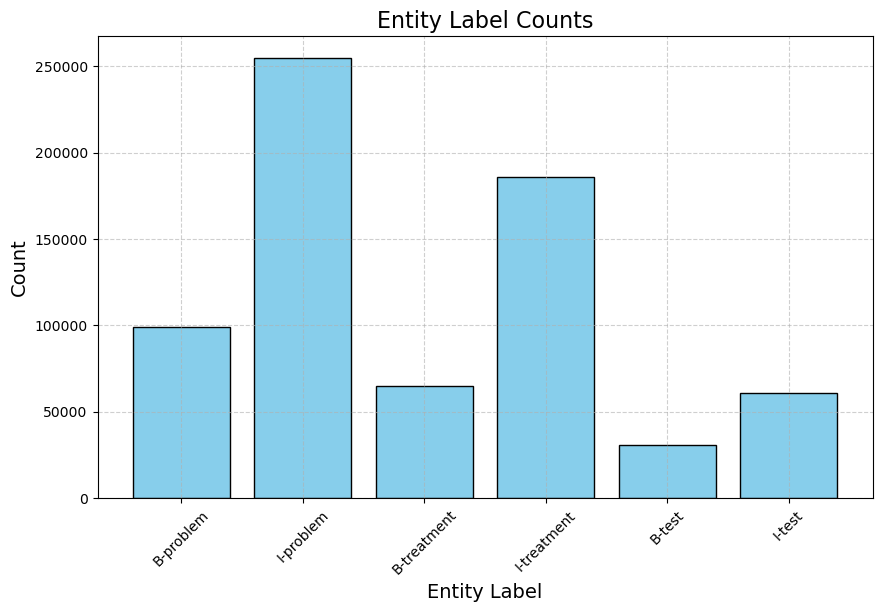

In [26]:
import matplotlib.pyplot as plt

# Prepare data for plotting
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue', edgecolor='black')

# Add labels and title
plt.title("Entity Label Counts", fontsize=16)
plt.xlabel("Entity Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)  # Rotate labels if needed
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [13]:
#Display the top 10 entities
print("\nSample entities:")
for entity in entities[:10]:
    print(entity)



Sample entities:
{'word': 'iron', 'entity': 'B-problem', 'score': 0.9986727}
{'word': 'deficiency', 'entity': 'I-problem', 'score': 0.9988495}
{'word': 'an', 'entity': 'I-problem', 'score': 0.9988937}
{'word': '##emia', 'entity': 'I-problem', 'score': 0.999084}
{'word': 'divert', 'entity': 'B-problem', 'score': 0.99799937}
{'word': '##ic', 'entity': 'I-problem', 'score': 0.99665725}
{'word': '##ulo', 'entity': 'I-problem', 'score': 0.9414925}
{'word': '##sis', 'entity': 'I-problem', 'score': 0.98919266}
{'word': 'colon', 'entity': 'B-treatment', 'score': 0.78555655}
{'word': '##os', 'entity': 'I-treatment', 'score': 0.41980204}


In [23]:
results = [entity for entity in entities if entity['score'] < 0.5]
print(len(results))
print(len(entities))


10871
696250


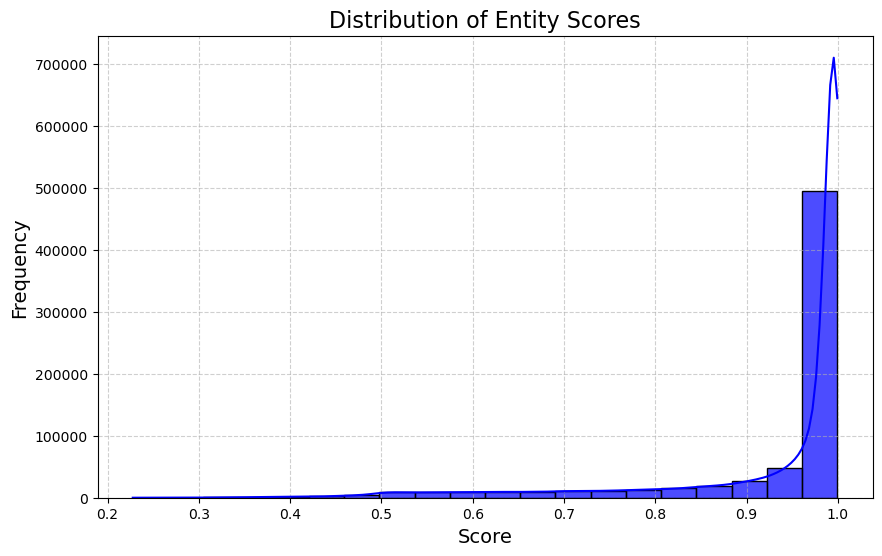

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `entities` is a list of dictionaries with "score" as one of the keys
scores = [entity["score"] for entity in entities]

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(scores, bins=20, kde=True, color='blue', alpha=0.7)

# Add labels and title
plt.title("Distribution of Entity Scores", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


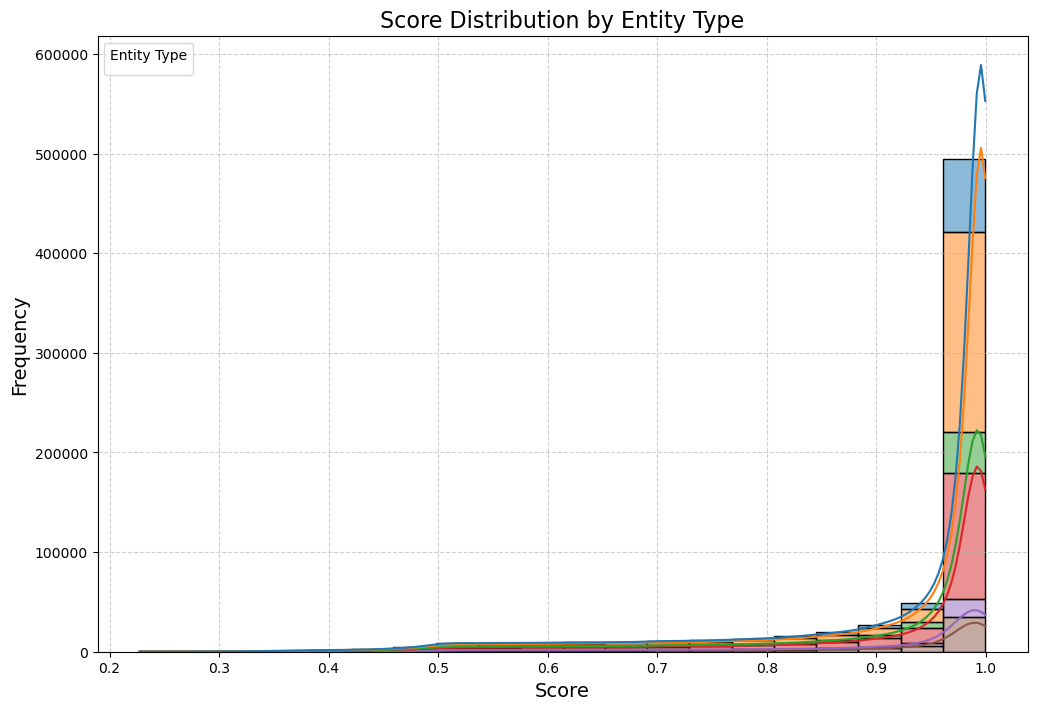

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming `entities` is a list of dictionaries with "entity" and "score" as keys
df = pd.DataFrame(entities)

# Plot the histogram for each entity type
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x="score", hue="entity", bins=20, kde=True, palette="tab10", multiple="stack")

# Customize the plot
plt.title("Score Distribution by Entity Type", fontsize=16)
plt.xlabel("Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(title="Entity Type")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


/var/folders/rl/kxnt4sxd1bs0cb7pxlj98tc00000gn/T/ipykernel_56599/2235505681.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="entity", y="score", palette="tab10")


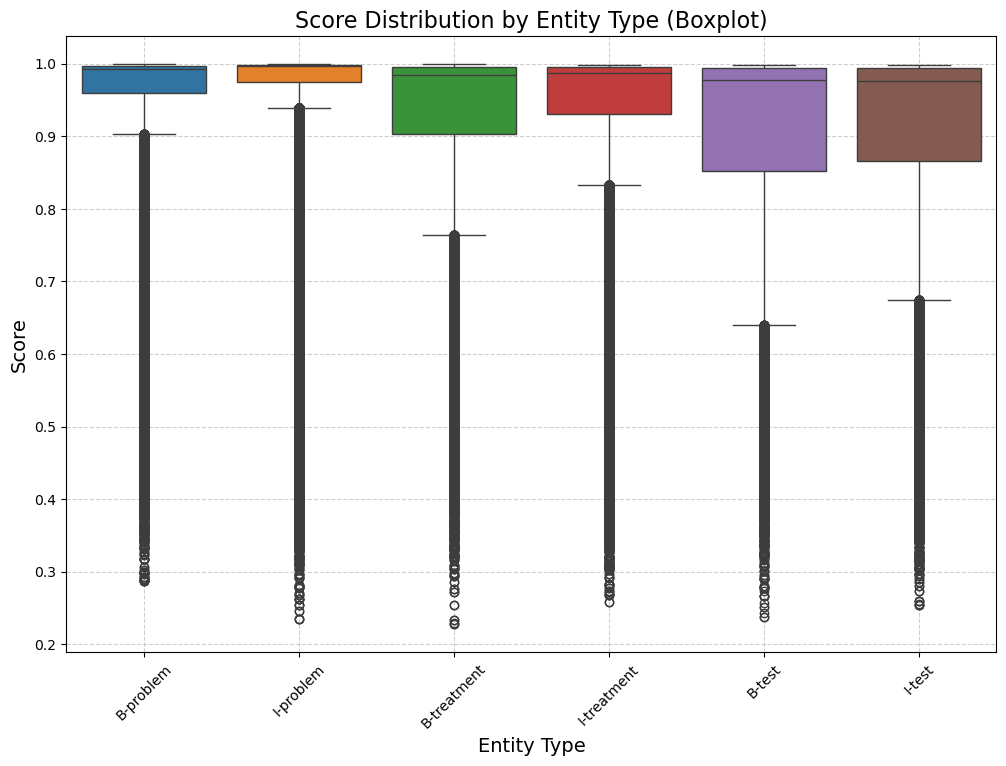

In [25]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x="entity", y="score", palette="tab10")

# Customize the plot
plt.title("Score Distribution by Entity Type (Boxplot)", fontsize=16)
plt.xlabel("Entity Type", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
